In [55]:
from roofline_utils import *
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import re

In [56]:
def load_results_csv(resultsCSV):

    if 'zero-shot' in resultsCSV:
        if 'SASS-only' in resultsCSV:
            modelName = resultsCSV[len('zero-shot-SASS-only-inference-results-'):-4]
        else:
            modelName = resultsCSV[len('zero-shot-inference-results-'):-4]
    else:
        if 'SASS-only' in resultsCSV:
            modelName = resultsCSV[len('few-shot-SASS-only-inference-results-'):-4]
        else:
            modelName = resultsCSV[len('few-shot-inference-results-'):-4]


    dtypes['language'] = 'string'
    dtypes['numTokens'] = np.int64
    dtypes['kernelCode'] = 'string'
    dtypes['kernelSASS'] = 'string'
    dtypes['isBB'] = np.int64
    dtypes['class'] = 'string'
    dtypes['answer'] = 'string'
    dtypes['topp'] = np.float64
    dtypes['temp'] = np.float64
    dtypes['llmResponse'] = 'string'
    dtypes['llmThought'] = 'string'
    dtypes['trial'] = np.int64
    dtypes['isTrain'] = np.int64

    df = pd.read_csv(resultsCSV, quotechar='\"', dtype=dtypes)
    return df, modelName

In [57]:
dfSASS, modelNameA = load_results_csv('zero-shot-SASS-only-inference-results-o3-mini-high.csv')
dfSrc, modelNameB = load_results_csv('zero-shot-inference-results-o3-mini-high.csv')
assert modelNameB == modelNameA

In [58]:
print(dfSASS.columns)

Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'kernelSASS', 'isBB', 'class', 'answer', 'isTrain',
       'trial', 'topp', 'temp', 'llmResponse', 'llmThought'],
      dtype='object')


In [59]:
# add the SASS token count columns
enc = tiktoken.encoding_for_model("gpt-4o-mini")

#dfSASS['numTokens'] = dfSASS['kernelSASS'].apply(lambda x: len(enc.encode(x)))
dfSASS['numTokensSASS'] = dfSASS['kernelSASS'].apply(lambda x: len(enc.encode(x)))
dfSrc['numTokensSASS'] = 0

In [60]:
# need to cleanup the LLM responses
def cleanup_responses(x):
    #print('input:', x)
    if not (str(x) == '<NA>'):
        matches = re.finditer(r'(Bandwidth|Compute)', x, re.MULTILINE)
        matches = [m for m in matches]
        if len(matches) > 1:
            # just take the last match
            print('\tMore than 1 match, taking last one!')
            matches = [matches[-1]]
        else:
            assert len(matches) == 1
        for match in matches:
            m = match.group()
            return m

    return 'NA'

dfSASS['llmResponse'] = dfSASS['llmResponse'].apply(cleanup_responses)
dfSrc['llmResponse'] = dfSrc['llmResponse'].apply(cleanup_responses)

In [61]:

dfSASS['isLLMCorrect'] = dfSASS.apply(lambda x: x['answer'] == x['llmResponse'], axis=1)
dfSrc['isLLMCorrect'] = dfSrc.apply(lambda x: x['answer'] == x['llmResponse'], axis=1)

In [62]:
# now we want to find instances in the mispredicted source code samples where the SASS predicted correctly

mispredSrc = dfSrc[dfSrc['isLLMCorrect'] == False]
print(mispredSrc.shape)
mispredTargets = mispredSrc['targetName'].to_list()
mispredKernels = mispredSrc['Kernel Name'].to_list()

correctRepredict = dfSASS[(dfSASS['targetName'].isin(mispredTargets)) & (dfSASS['Kernel Name'].isin(mispredKernels)) & (dfSASS['isLLMCorrect'] == True)]

print(correctRepredict.shape)

grouped = correctRepredict.groupby(['language'])['isLLMCorrect'].count()
print(grouped)

(122, 30)
(78, 31)
language
CUDA    41
OMP     37
Name: isLLMCorrect, dtype: int64


In [77]:
# join both dataframes so we have the "ideal" dataframe

print(dfSrc.shape, dfSASS.shape)

joined = pd.merge(dfSrc, dfSASS, on=['targetName', 'Kernel Name'], how='inner')

# 0 if both got it wrong, 1 if only SASS got it right, 2 if only SRC got it right, 3 if both got right 
joined['predictType'] = ''

joined.loc[(joined.isLLMCorrect_x==False) & (joined.isLLMCorrect_y==False), 'predictType'] = 'SRC:0, SASS:0'
joined.loc[(joined.isLLMCorrect_x==False) & (joined.isLLMCorrect_y==True), 'predictType'] = 'SRC:0, SASS:1'
joined.loc[(joined.isLLMCorrect_x==True) & (joined.isLLMCorrect_y==False), 'predictType'] = 'SRC:1, SASS:0'
joined.loc[(joined.isLLMCorrect_x==True) & (joined.isLLMCorrect_y==True), 'predictType'] = 'SRC:1, SASS:1'

print(joined.shape)
print(joined.columns)


(340, 30) (333, 31)
(333, 60)
Index(['Kernel Name', 'traffic_x', 'dpAI_x', 'spAI_x', 'dpPerf_x', 'spPerf_x',
       'xtime_x', 'Block Size_x', 'Grid Size_x', 'device_x', 'intops_x',
       'intPerf_x', 'intAI_x', 'targetName', 'exeArgs_x', 'kernelName_x',
       'language_x', 'numTokens_x', 'kernelCode_x', 'isBB_x', 'class_x',
       'answer_x', 'isTrain_x', 'trial_x', 'topp_x', 'temp_x', 'llmResponse_x',
       'llmThought_x', 'numTokensSASS_x', 'isLLMCorrect_x', 'traffic_y',
       'dpAI_y', 'spAI_y', 'dpPerf_y', 'spPerf_y', 'xtime_y', 'Block Size_y',
       'Grid Size_y', 'device_y', 'intops_y', 'intPerf_y', 'intAI_y',
       'exeArgs_y', 'kernelName_y', 'language_y', 'numTokens_y',
       'kernelCode_y', 'kernelSASS', 'isBB_y', 'class_y', 'answer_y',
       'isTrain_y', 'trial_y', 'topp_y', 'temp_y', 'llmResponse_y',
       'llmThought_y', 'numTokensSASS_y', 'isLLMCorrect_y', 'predictType'],
      dtype='object')


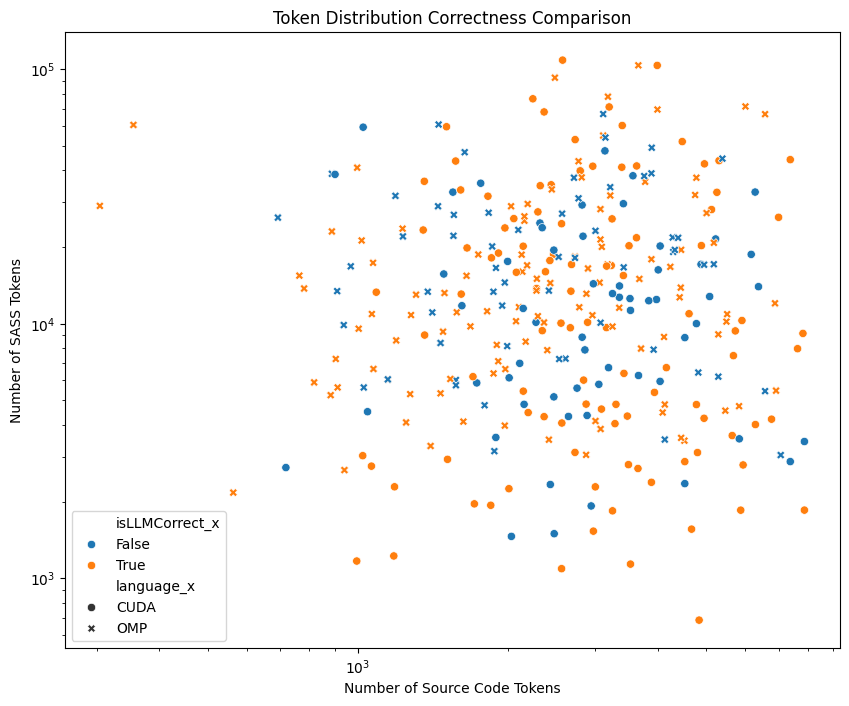

In [78]:
# is there a relationship between number of tokens and correct predictions?
assert joined['numTokens_x'].equals(joined['numTokens_y'])

fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.scatterplot(joined, x='numTokens_x', y='numTokensSASS_y', hue='isLLMCorrect_x', style='language_x', ax=ax)

ax.set_title('Token Distribution Correctness Comparison')

ax.set_xlabel('Number of Source Code Tokens')
ax.set_ylabel('Number of SASS Tokens')
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

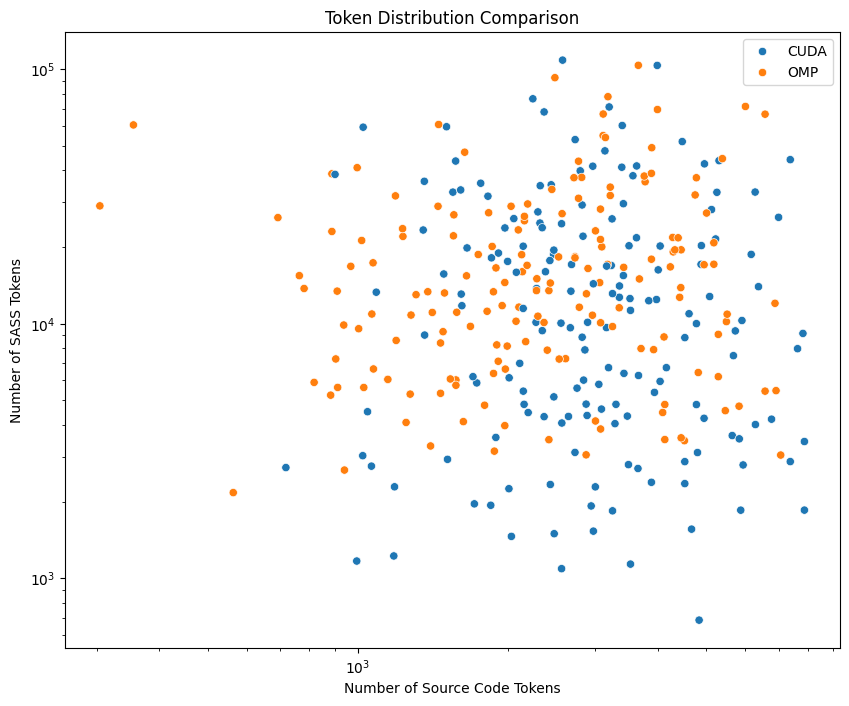

In [88]:

fig, ax = plt.subplots(1,1, figsize=(10,8))

sns.scatterplot(joined, x='numTokens_x', y='numTokensSASS_y', hue='language_x', ax=ax)
#sns.kdeplot(joined, x='numTokens_x', y='numTokensSASS_y', hue='language_x', ax=ax, levels=5, thresh=.2)

ax.set_title('Token Distribution Comparison')

ax.set_xlabel('Number of Source Code Tokens')
ax.set_ylabel('Number of SASS Tokens')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')

plt.show()

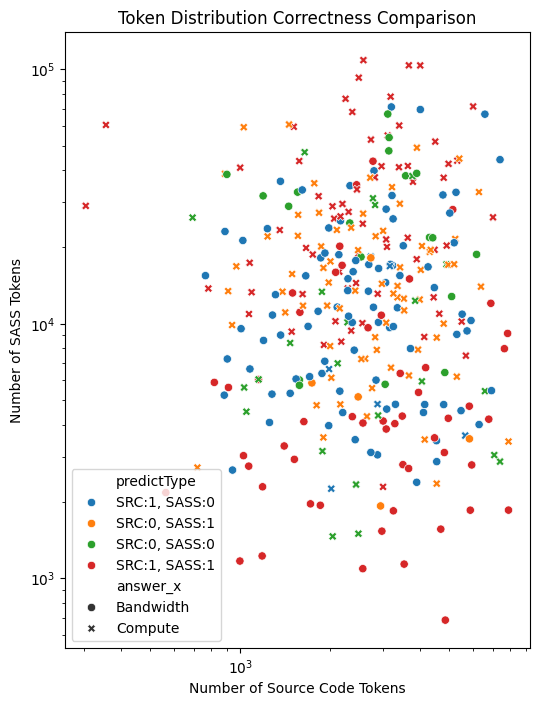

In [92]:

fig, ax = plt.subplots(1,1, figsize=(6,8))

#sns.scatterplot(joined, x='numTokens_x', y='numTokensSASS_y', hue='predictType', style='language_x', ax=ax)
sns.scatterplot(joined, x='numTokens_x', y='numTokensSASS_y', hue='predictType', style='answer_x', ax=ax)

ax.set_title('Token Distribution Correctness Comparison')

ax.set_xlabel('Number of Source Code Tokens')
ax.set_ylabel('Number of SASS Tokens')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best')

plt.show()

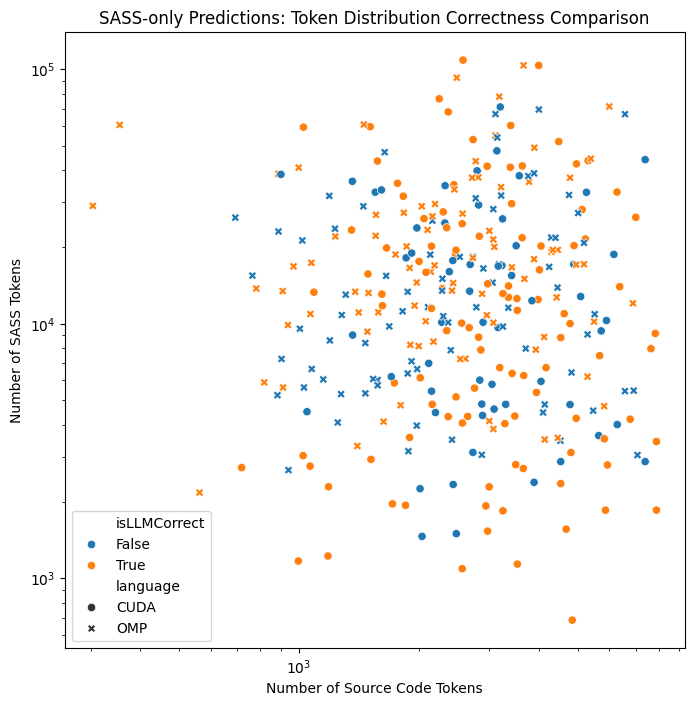

In [80]:

fig, ax = plt.subplots(1,1, figsize=(8,8))

sns.scatterplot(dfSASS, x='numTokens', y='numTokensSASS', hue='isLLMCorrect', style='language', ax=ax)

ax.set_title('SASS-only Predictions: Token Distribution Correctness Comparison')

ax.set_xlabel('Number of Source Code Tokens')
ax.set_ylabel('Number of SASS Tokens')
ax.set_xscale('log')
ax.set_yscale('log')

plt.show()